<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/FinalEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image, ImageOps
import sys
import statistics


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Preparation for SeqNet**

In [9]:
IMG_PATH = "/content/drive/MyDrive/Deep_learning/FundusPhoto/img_train/img00265140_00_2L.jpg"

In [5]:
#GithubよりSeqNetをcloneする
os.chdir('/content')
!git clone https://github.com/conscienceli/SeqNet.git

#出力用フォルダを作る
output_path = "/content/SeqNet/SeqNet_output"
os.makedirs(output_path, exist_ok=True)

#作業ディレクトリをpathに移動する
os.chdir('/content/SeqNet')
#評価画像用のフォルダを作成
data_dir = "./data/test_images/"
os.makedirs(data_dir, exist_ok=True)

#Download pretrained model from Gdrive
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1OYjzu0gixtga6e7Rvb2mZoSSYJkXWRNB'

os.makedirs('./trained_model/ALL', exist_ok=True)
destination = './trained_model/ALL/Final_Emer_Iteration_3_cropsize_128_epochs_200.hdf5'
download_file_from_google_drive(file_id, destination)


#upgrade modules
!pip3 install --upgrade tensorflow==1.15.0
!pip3 install --upgrade keras==2.3.1
!pip3 install --upgrade h5py==2.10.0

#stride_sizeを増やす事によるタイムコスト削減
!cat -n predict.py # -n はnumberの意味
!sed -i -e "133c predict(batch_size=24, epochs=200, iteration=3, stride_size=10, crop_size=128," predict.py

fatal: destination path 'SeqNet' already exists and is not an empty directory.
     1	############Test
     2	import argparse
     3	import os
     4	import tensorflow as tf
     5	from keras.backend import tensorflow_backend
     6	
     7	from utils import define_model, crop_prediction
     8	from keras.layers import ReLU
     9	from tqdm import tqdm
    10	import numpy as np
    11	from skimage.transform import resize
    12	import cv2
    13	
    14	from PIL import Image
    15	
    16	
    17	def predict(ACTIVATION='ReLU', dropout=0.1, batch_size=32, repeat=4, minimum_kernel=32, 
    18	            epochs=200, iteration=3, crop_size=128, stride_size=3, 
    19	            input_path='', output_path='', DATASET='ALL'):
    20	    exts = ['png', 'jpg', 'tif', 'bmp', 'gif']
    21	
    22	    if not input_path.endswith('/'):
    23	        input_path += '/'
    24	    paths = [input_path + i for i in sorted(os.listdir(input_path)) if i.split('.')[-1] in exts]
    25	
    26	    gt_li

In [12]:
def Mirror_left_eye(pil_img, img_path):
    filename = os.path.splitext(IMG_PATH)[0]
    side = filename[-1]
    if side == "R":
        flipped_img = pil_img
    elif side == "L":
        img_mirror = ImageOps.mirror(pil_img)
        flipped_img = img_mirror
    return flipped_img

def crop2square(pil_img):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = pil_img.crop(((width-height)//2, 0, (width+height)//2, height))
        return result
    else:
        result = pil_img.crop((0, (height-width)//2, width, (height+width)//2))
        return result

def crop_disc(pil_img):
    width, height = pil_img.size
    if width % 10 != 0:
        print("幅を10等分できません")
    if height % 10 != 0:
        print("高さを10等分できません")
    x_axis = int(width/10)
    y_axis = int(height/10)
    disc_img = pil_img.crop((5*x_axis, 3*y_axis, 9*x_axis, 7*y_axis))
    return disc_img

def crop_macula(pil_img):
    width, height = pil_img.size
    if width % 20 != 0:
        print("幅を5等分できません")
    if height % 20 != 0:
        print("高さを5等分できません")
    x_axis = int(width/20)
    y_axis = int(height/20)

    macula_img = pil_img.crop((4*x_axis, 7*y_axis, 10*x_axis, 13*y_axis))
    return macula_img



In [ ]:
orig_img = Image.open(IMG_PATH)
flipped_img = Mirror_left_eye(orig_img, IMG_PATH)
cropped_img = crop2square(flipped_img)
disc_img = crop_disc(cropped_img)
macula_img = crop_macula(cropped_img)

###SeqNet用の下準備

SeqNet_PATH = '/content/SeqNet/'
#作業ディレクトリをpathに移動する
os.chdir(SeqNet_PATH)
#評価画像用のフォルダを作成
cropped_img.save(data_dir + "temp.jpg")
!python predict.py -i /content/SeqNet/data/test_images/ -o /content/SeqNet/SeqNet_output/



Using TensorFlow backend.



2021-09-28 03:03:06.340550: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-09-28 03:03:06.346263: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-09-28 03:03:06.346559: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563365958a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-28 03:03:06.346596: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-28 03:03:06.349068: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-28 03:03:06.362453: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-28 03:03:06.362526: I tensorflow/stream_executor/

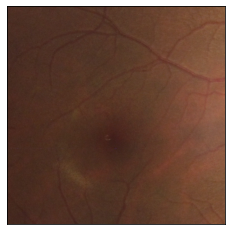

In [17]:
#画像の読み込み
#im = Image.open(IMG_PATH)
#画像をarrayに変換
im_list = np.asarray(macula_img)
#軸を非表示
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.tick_params(bottom=False, left=False, right=False, top=False)
#貼り付け
plt.imshow(im_list)
#表示
#plt.show()